In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [2]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 2):
        super(AlexNet, self).__init__()

        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.convolutional(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.linear(x)
        return torch.softmax(x, 1)

In [3]:
model = AlexNet()
model = model.to(device)

In [4]:
'''with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")'''

'with zipfile.ZipFile("celeba.zip","r") as zip_ref:\n  zip_ref.extractall("data_faces/")'

In [5]:

root = '/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [6]:

df = pd.read_csv("/home/luser/autoencoder_attacks/train_aautoencoders/list_attr_celeba.csv")
df = df[['image_id', 'Young']]

In [7]:
df
#get all the row titles
df.index
# get all the column titles
df.columns

Index(['image_id', 'Young'], dtype='object')

In [8]:
# to make directories

'''!rm -rf data
!mkdir data && mkdir data/male && mkdir data/no_male'''

'!rm -rf data\n!mkdir data && mkdir data/male && mkdir data/no_male'

In [9]:

s0 = 0
s1 = 0

num = 45000

for i, (_, i_row) in enumerate(df.iterrows()):
  if s0 < num:
    if i_row['Young'] == 1:
      s0 += 1
      shutil.copyfile('/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba/' + i_row['image_id'], 'data_age/young/' + i_row['image_id'])
  
  if s1 < num:
    if i_row['Young'] == -1:
      s1 += 1
      shutil.copyfile('/home/luser/autoencoder_attacks/train_aautoencoders/data_faces/img_align_celeba/' + i_row['image_id'], 'data_age/no_young/' + i_row['image_id'])
  
  if s0 == num and s1 == num:
    break

In [10]:
young_list = os.listdir('data_age/young/')
print(len(young_list))
old_list = os.listdir('data_age/no_young/')
print(len(old_list))

45000
45000


In [11]:

img_list = os.listdir('data_age/young/')
img_list.extend(os.listdir('data_age/no_young/'))

In [12]:
print("Images: ", len(img_list))


Images:  90000


In [13]:

transform = transforms.Compose([
          transforms.Resize((64, 64)),
          transforms.ToTensor()
          ])

batch_size = 64
celeba_data = datasets.ImageFolder('data_age', transform=transform)

In [14]:
print(celeba_data.classes)
print(len(celeba_data))

['no_young', 'young']
90000


In [15]:

train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [16]:
trainLoader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [17]:
print(train_data_size)
print(test_data_size)

67500
22500


In [18]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [19]:
epochs = 10
train_loss = []

for epoch in range(epochs):
   
    total_train_loss = 0
    
    # training our model
    for idx, (image, label) in enumerate(trainLoader):
        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()
        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    print(f'Epoch: {epoch} | Train Loss: {total_train_loss}')

Epoch: 0 | Train Loss: 0.5870157707358988
Epoch: 1 | Train Loss: 0.5483132745417374
Epoch: 2 | Train Loss: 0.5340469046791583
Epoch: 3 | Train Loss: 0.5221611863346461
Epoch: 4 | Train Loss: 0.5133124841333001
Epoch: 5 | Train Loss: 0.504257061498425
Epoch: 6 | Train Loss: 0.49731101690310436
Epoch: 7 | Train Loss: 0.49084954049914936
Epoch: 8 | Train Loss: 0.48336737811282915
Epoch: 9 | Train Loss: 0.4771784885799715


In [20]:
torch.save(model.state_dict(), '/home/luser/robustness_of_subgroups/saved_gender_classifier/age_classifier.torch')

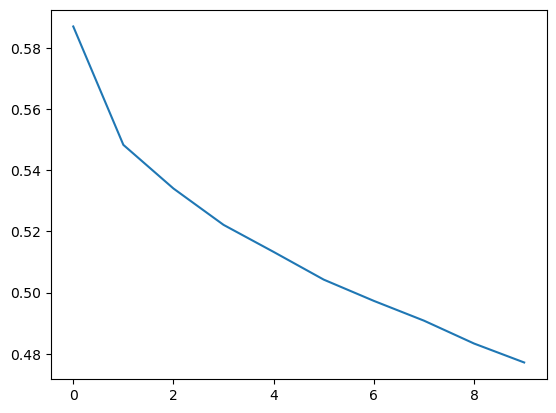

In [21]:
plt.plot(train_loss)


In [22]:
testiter = iter(testLoader)
images, labels = next(testiter)

with torch.no_grad():
  images, labels = images.to(device), labels.to(device)
  pred = model(images)

images_np = [i.cpu() for i in images]
class_names = celeba_data.classes

predictions = np.argmax(pred.cpu().numpy(), 1)

In [23]:
predictions

array([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0])

In [24]:
np.argmax(pred.cpu().numpy(), 1), labels

(array([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0]),
 tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1,
         1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0'))

In [33]:
for i in range(len(pred)):
    print(labels[i] == torch.max(pred[i], 0)[1])

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cuda:0')
tensor(True, device='cud

In [25]:
for idx, (image, label) in enumerate(testLoader):
    with torch.no_grad():
        image, label = image.to(device), label.to(device)
        pred = model(image)
        break

In [26]:
label

tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')

In [27]:
torch.argmax(pred)

tensor(0, device='cuda:0')

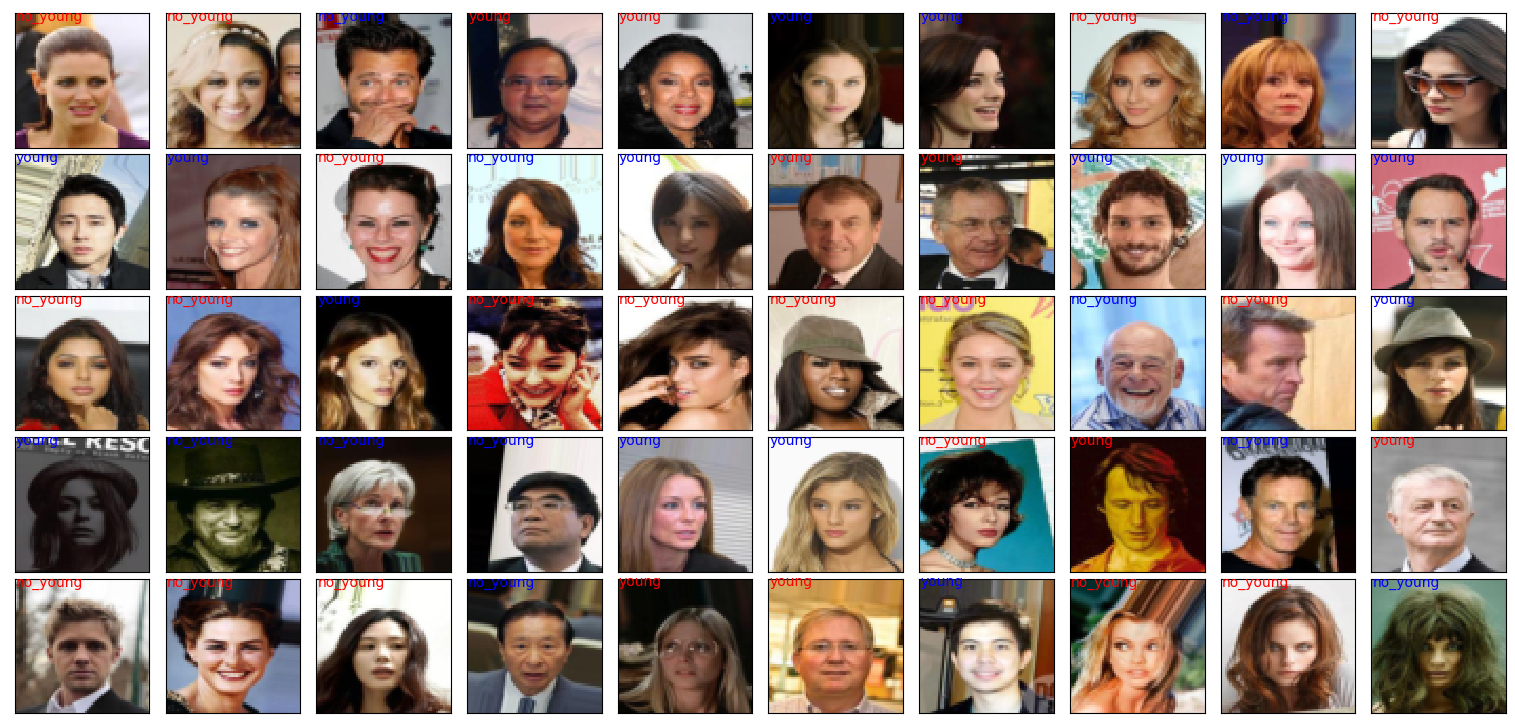

In [29]:

fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[i].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[i] == torch.max(pred[i], 0)[1]:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='blue')
    else:
      ax.text(0, 3, class_names[torch.max(pred[i], 0)[1]], color='red')